## Acoustic wave simulation in time domain

Loading plotting and Acoustic wave packages.

In [2]:
using SeisPlot, SeisAcoustic, LinearAlgebra

Create a simple two layers velocity model with constant density, size of this model is $101 \times 301$

In [3]:
nz = 101; nx = 301;
vel = 3000 * ones(nz, nx);  # m/s
vel[51:end,:] .= 3500;  
rho = 2000 * ones(nz, nx);  # kg/m^3

Plot the velocity model

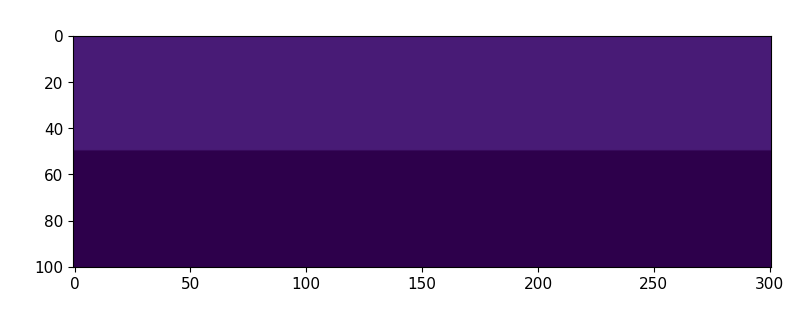

In [4]:
SeisPlotTX(vel, wbox=9, hbox=3);

Specify the boundary conditions

In [5]:
# number of PML layers
npml = 20;

# free surface for top boundary condition
free_surface = true;   

Grid size

In [6]:
# vertical and horizontal grid size
dz = 10; dx = 10;

# time step size and maximum modelling length
dt = 0.001; tmax = 2.0;  # use second as unit

Discretize acoustic wave-equation via finite difference method and generating stencil

In [7]:
params = TdParams(rho, vel, free_surface, dz, dx, dt, tmax;
         data_format=Float64, fd_flag="taylor", order=2, npml=20, apml=900.);

In [64]:
?TdParams

search: TdParams



immutable struct contain the model parameters

  * data_format : Float32 or Float64
  * nz          : depth of model
  * nx          : length of model
  * npml        : number of PML layers
  * free_surface: true -> no obsorbtion on the surface                false-> PML on the surface
  * Nz          : depth of model (include PML padding)
  * Nx          : length of model (include PML padding)
  * ntop        : number of padded PML layers on the top
  * spt2wfd     : auxillary index vector for computing wavefield from snapshot
  * spt2bnd     : auxillary index vector for computing wavefield boundaries from snapshot
  * bnd2wfd     : auxillary index vector for inserting wavefield boundaries to wavefield
  * dz          : vertical grid size
  * dx          : horizontal grid size
  * dt          : time step size
  * tmax        : maximum modelling length
  * nt          : number of time steps
  * rho         : 2D density model
  * vel         : 2D P-wave velocity model
  * MvzBvz      : FD stencil for updating v*z from v*z, vector length of Nz
  * MvzBp       : FD stencil for updating v_z from p  , vector length of Nz * Nx
  * dpdz        : sparse matrix computing dp/dz
  * MvxBvx      : FD stencil for updating v*x from v*x, vector length of Nx
  * MvxBp       : FD stencil for updating v_x from p  , vector length of Nz * Nx
  * dpdx        : sparse matrix computing dp/dx
  * MpzBpz      : FD stencil for updating p*z from p*z, vector length of Nz
  * MpzBvz      : FD stencil for updating p*z from v*z, vector length of Nz * Nx
  * dvdz        : sparse matrix computing dvz/dz
  * MpxBpx      : FD stencil for updating p*x from p*x, vector length of Nx
  * MpxBvx      : FD stencil for updating p*x from v*x, vector length of Nz * Nx
  * dvdx        : sparse matrix computing dvx/dx
  * RvzBp       : FD stencil for updating v_z from p, vector length of nz * nx
  * rpdz        : sparse matrix computing dp/dz
  * RvxBp       : FD stencil for updating v_x from p, vector length of nz * nx
  * rpdx        : sparse matrix computing dp/dx
  * RpzBvz      : FD stencil for updating p*z from v*z, vector length of nz * nx
  * rvdz        : sparse matrix computing dv/dz
  * RpxBvx      : FD stencil for updating p*x from v*x, vector length of nz * nx
  * rvdx        : sparse matrix computing dv/dx

---

the constructor for TdParams


Initialize  a single point source, the first two parameters are the index location of this point source.

In [8]:
src = Source(2, 150, params; ot=0.0, fdom=20.0,
      type_flag="ricker", amp=100000, location_flag="index");

In [66]:
fieldnames(Source)

(:isz, :isx, :src2spt, :src2wfd, :dt, :it_min, :it_max, :p)

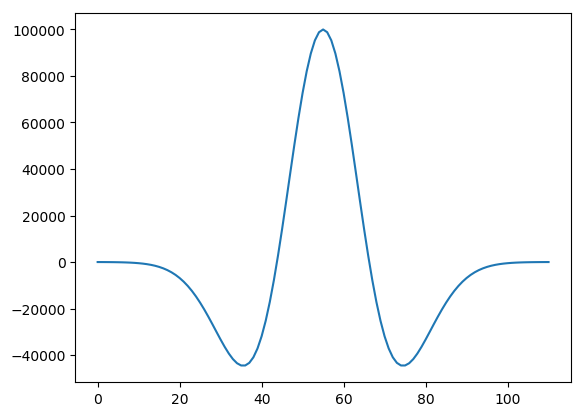

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x141055438>

In [9]:
# plotting the source time function
plot(src.p)

Initialize the recording structure which require the locations of receivers

In [10]:
irx = collect(1:2:params.nx);
irz = 2 * ones(length(irx));
rec = Recordings(irz, irx, params);

In [67]:
fieldnames(Recordings)

(:nt, :nr, :dt, :irz, :irx, :spt2rec, :p)

Generate one shot gather

In [11]:
multi_step_forward!(rec, src, params);

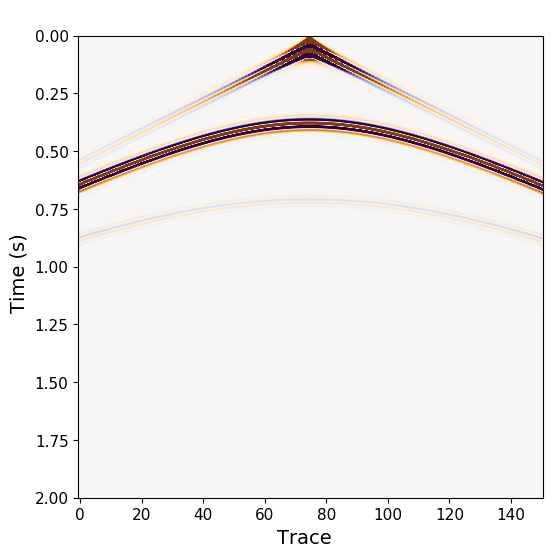

In [12]:
# plotting the shot gather
SeisPlotTX(rec.p, pclip=98, dy=0.001, ylabel="Time (s)", xlabel="Trace");

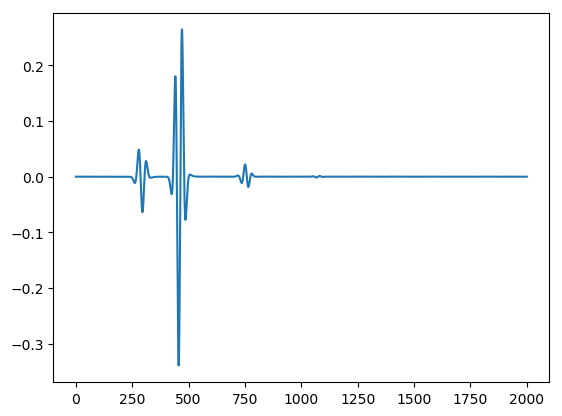

In [13]:
# plot one trace
plot(rec.p[:,40]);

This package also support simultaneous source modelling. The source term is consisted by a vector, each element of this vector is a source structure.

In [14]:
# initialize multi-sources
isx = collect(5:60:295);           # horizontal location
ns=length(isx); isz = 2*ones(ns);  # vertical location
ot  = 0.5*rand(ns);                # activation time
srcs = get_multi_sources(isz, isx, params; amp=100000, ot=ot, fdom=15); # get a vector of source

In [15]:
# forward modelling
multi_step_forward!(rec, srcs, params);

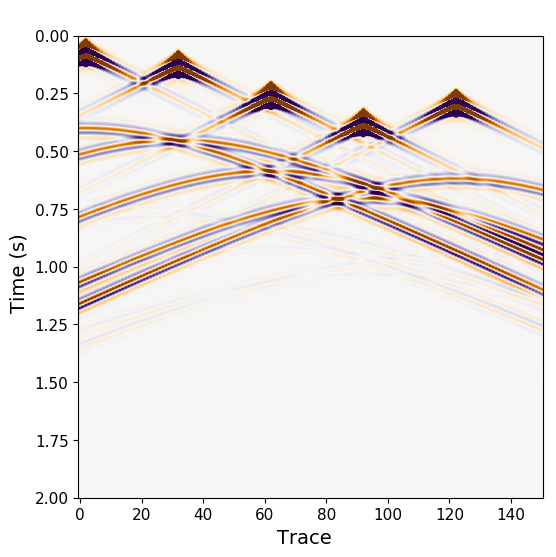

In [17]:
# plotting the blending data
SeisPlotTX(rec.p, pclip=98, dy=0.001, ylabel="Time (s)", xlabel="Trace");

## Gradient of Acoustic FWI 

### Gradient based on adjoint method

In [19]:
# two-layer velocity model
nz = 101; nx = 301;
vel = 3000 * ones(nz, nx);  # m/s
vel[51:end,:] .= 3500;  
rho = 2000 * ones(nz, nx);  # kg/m^3

# vertical and horizontal grid size
dz = 10; dx = 10;

# time step size and maximum modelling length
dt = 0.001; tmax = 2.0;  # use second as unit

params = TdParams(rho, vel, free_surface, dz, dx, dt, tmax;
         data_format=Float64, fd_flag="taylor", order=2, npml=20, apml=900.);

In [20]:
# Source term
src = Source(2, 150, params; ot=0.0, fdom=20.0,
      type_flag="ricker", amp=100000, location_flag="index");

In [27]:
#recordings
irx = collect(1:2:params.nx);
irz = 2 * ones(length(irx));
dobs= Recordings(irz, irx, params);
multi_step_forward!(dobs, src, params);

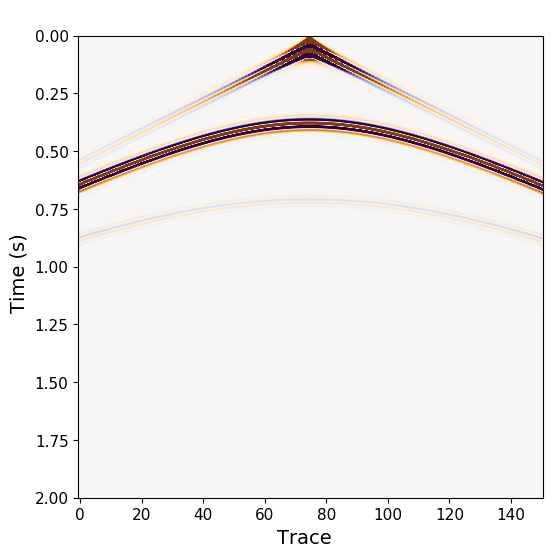

In [28]:
# plotting the recordings
SeisPlotTX(dobs.p, pclip=98, dy=0.001, ylabel="Time (s)", xlabel="Trace");

### Homogeneous initial velocity model

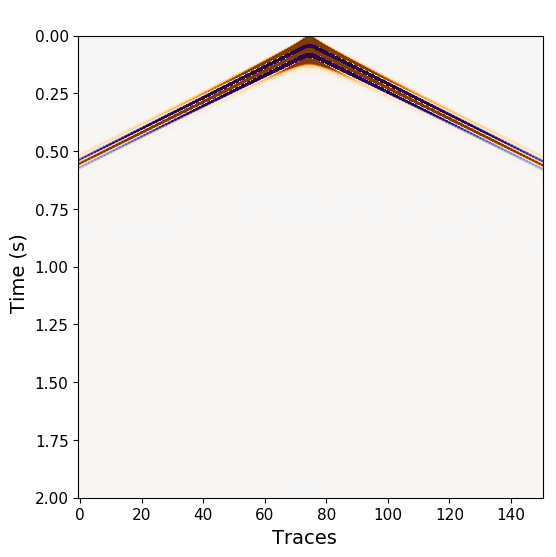

In [29]:
# initial velocity model
vel0 = 3000 * ones(nz, nx);
params0 = TdParams(rho, vel0, free_surface, dz, dx, dt, tmax; data_format=Float64);

# generate synthetic data and save the boundary value which will be used for source-side wavefield reconstruction
path_bnd = joinpath(homedir(), "Desktop/bnd.rsb");
path_wfd = joinpath(homedir(), "Desktop/wfd.rsb");
dsyn = Recordings(irz, irx, params0);

# forward modelling and boundary wavefield is savd for reconstructing source side wavefield
multi_step_forward!(dsyn, src, params0; path_bnd=path_bnd, path_wfd=path_wfd);
SeisPlotTX(dsyn.p, xlabel="Traces", ylabel="Time (s)", dy=0.001);

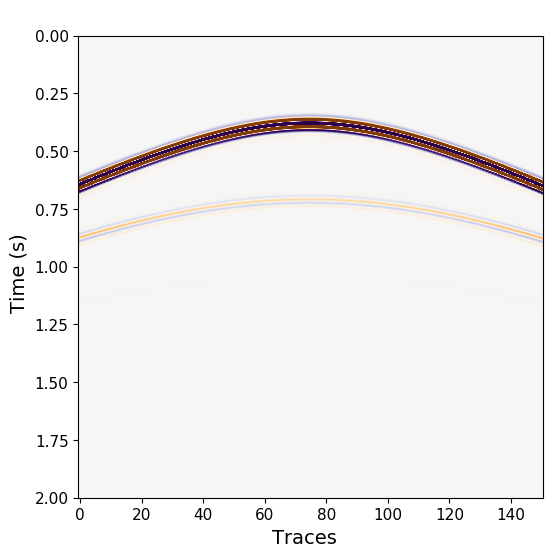

In [30]:
# compute the residue
dres = get_residue(dsyn, dobs);
SeisPlotTX(dres.p, xlabel="Traces", ylabel="Time (s)", dy=0.001);

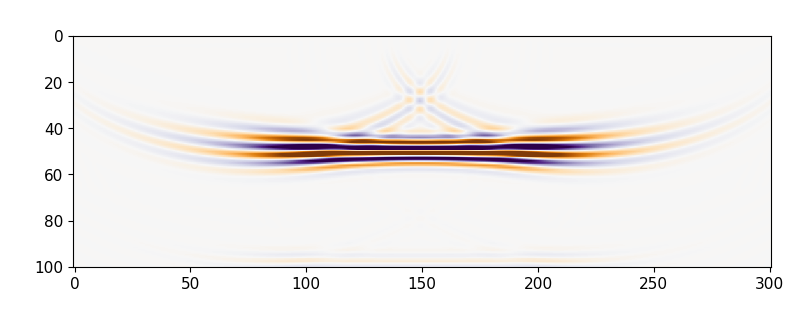

im

In [63]:
# get the gradient of objective with respect to velocity model
g_adj = velocity_gradient(dres, path_bnd, path_wfd, src, params0);
g_adj = reshape(g_adj, nz, nx)
SeisPlotTX(g_adj, wbox=9, hbox=3)

### Check the accuracy of the gradient
Objective function $J$ is the $l2$ norm of the difference between synthetic data and observations.
$$
J = \frac{1}{2}|| d_{syn} - d_{obs}||_2^2
$$
We can compute the gradient numerically
$$\frac{\partial J}{\partial m_l} = \frac{J(m_l + \delta m_l) - J(m_l - \delta m_l)}{2\delta m_l}$$

In [35]:
# velocity model pertubation
delta_m = 1e-7;

In [54]:
# compute the derivative of objective function with respect to one model parameter
iz = 52; ix = 100;

$$m_l = m_l + \delta m_l$$
and the relationship between the linear index $l$ and sub-index $iz$, $ix$ is 
$$l = (ix-1) \times nz + iz$$

In [55]:
vel0 = 3000 * ones(nz, nx);
vel0[iz,ix] = vel0[iz,ix] + delta_m;

In [56]:
# stencils corresponding to current model
params0 = TdParams(rho, vel0, free_surface, dz, dx, dt, tmax; data_format=Float64);

Generate synthetic data

In [57]:
# Using the 2-layers velocity model to generate observations
dsyn = Recordings(irz, irx, params0);
multi_step_forward!(dsyn, src, params0);

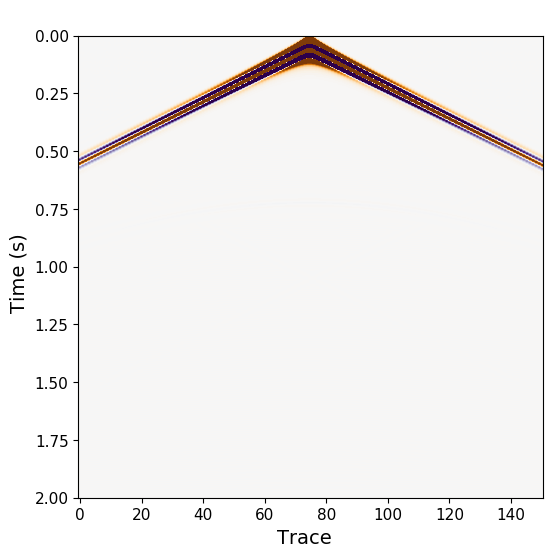

In [58]:
# plotting the synthetic data
SeisPlotTX(dsyn.p, pclip=98, dy=0.001, ylabel="Time (s)", xlabel="Trace");

Compute cost
$$
J(m_l + \delta m_l) = \frac{1}{2}|| d_{syn} - d_{obs}||_2^2
$$

In [59]:
# get the objective
dres = get_residue(dsyn, dobs)
J_plus = (norm(dres.p))^2 / 2.0

144.0292159672435

Pertubate model parameter negatively
$$m_l = m_l - \delta m_l$$

In [60]:
vel0[iz,ix] = vel0[iz,ix] - 2*delta_m;

# generate stencil corresponding to current model
params0 = TdParams(rho, vel0, free_surface, dz, dx, dt, tmax; data_format=Float64);

# generate synthetic data
multi_step_forward!(dsyn, src, params0);

# get data residue
dres = get_residue(dsyn, dobs);

# objective function
J_minus = norm(dres.p)^2 / 2.0;

In [61]:
# Compute the derivative numerically
g_num = (J_plus - J_minus) / (2 * delta_m)

-0.0030178171073202975

In [62]:
g_adj[iz,ix]

-0.0030176313792494715

Taylor's expansion
$$
\begin{align}
f(x+\delta) &= f(x) + f^{\prime}(x)\delta + O(\delta^2) \\
f(x-\delta) &= f(x) - f^{\prime}(x)\delta + O(\delta^2) \\
\end{align}
$$
We can get the approximation to the first-order derivative of $f(x)$
$$
2f^{\prime}(x)\delta  = f(x+\delta) - f(x-\delta) + O(\delta^2) 
$$
So the first order approximation is
$$
\begin{align}
f^{\prime}(x) &= \frac{f(x+\delta) - f(x-\delta)}{2\delta} + \frac{O(\delta^2)}{2\delta} \\
&= \frac{f(x+\delta) - f(x-\delta)}{2\delta} + O(\delta)
\end{align}
$$